- The given problem is related with time wasted in granting and revoking access to the employee within company.  For employee to access any resources he/she needs prior permission i.e. access of that resource. The access granting and revoking process is manual, handled by superviso. As employees move throughout a company, this access discovery/recovery cycle wastes a nontrivial amount of time and money.

- <b>Objective:</b> We have to build a model, learned using historical data, that will determine an employee's access needs, such that manual access transactions (grants and revokes) are minimized as the employee's attributes change over time. The model will take an employee's role information and a resource code and will return whether or not access should be granted.


- <b>Data:</b> In training dataset, each row has the ACTION (ground truth), RESOURCE, and information about the employee's role at the time of approval.
- Following are the features present in the training dataset:
    - ACTION: Target variable. ACTION is 1 if the resource was approved, 0 if the resource was not approved.
    - RESOURCE: An ID for each resource
    - MGR_ID: The EMPLOYEE ID of the manager of the current EMPLOYEE ID record; an employee may have only one manager at a time
    - ROLE_ROLLUP_1: Company role grouping category id 1 (e.g. US Engineering)
    - ROLE_ROLLUP_2: Company role grouping category id 2 (e.g. US Retail)
    - ROLE_DEPTNAME: Company role department name (e.g. Retail)
    - ROLE_TITLE: Company role business title description (e.g. Senior Engineering Retail Manager)
    - ROLE_FAMILY_DESC: Company role family extended description (e.g. Retail Manager, Software Engineering)
    - ROLE_FAMILY: Company role family description (e.g. Retail Manager)
    - ROLE_CODE: Company role code; this code is unique to each role (e.g. Manager)
 
 
- All features has numerical values but all features are categorical features.

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [5]:
Importing Datasets

SyntaxError: invalid syntax (<ipython-input-5-5921c63ba97a>, line 1)

In [15]:
ls

 Volume in drive C is Windows
 Volume Serial Number is 6E73-904C

 Directory of C:\Users\THIS PC\Desktop\results EMP ACESS

01-03-2022  09:57    <DIR>          .
01-03-2022  09:50    <DIR>          ..
28-02-2022  21:19    <DIR>          .ipynb_checkpoints
20-08-2021  22:24    <DIR>          data
20-08-2021  22:17         1,585,657 emp results.docx
20-08-2021  22:22           207,394 employee access challenge pdf-converted-converted.pdf
01-03-2022  09:57           311,583 predicting_an_employee_s_access_needs.ipynb
               3 File(s)      2,104,634 bytes
               4 Dir(s)  51,114,344,448 bytes free


In [16]:
data = pd.read_csv('./data/train.csv')
print(data.shape)
data.head()

(32769, 10)


,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


## Step 2: Data Exploration

In [17]:
data_explore = data.copy()

In [19]:
data.info()

TypeError: Cannot interpret '<attribute 'dtype' of 'numpy.generic' objects>' as a data type

In [18]:
data_explore.info()

TypeError: Cannot interpret '<attribute 'dtype' of 'numpy.generic' objects>' as a data type

There is no column with null values.

In [ ]:
data_explore.nunique()

- In dataset description it is mention that an employee can have only one manager at a time, then we can consider that the dataset contains information of maximum 4243 employees.
- There are same number of unique values for ROLE_TITLE and ROLE_CODE. There is 1-to-1 mapping between these columns. So for our problem only one feature is sufficent.

In [ ]:
sns.countplot(x='ACTION', data=data_explore)

- We can see that we have imbalance dataset. There are very less records of not granting the access.

- Lets find out top 15 Resources, Role department, Role family, Role codes for which most access is requested.

In [ ]:
data_explore_resources = data_explore[['RESOURCE', "ACTION"]].groupby(by='RESOURCE').count()
data_explore_resources.sort_values('ACTION', ascending=False).head(n=15).transpose()

In [ ]:
data_explore_role_dept = data_explore[['ROLE_DEPTNAME', "ACTION"]].groupby(by='ROLE_DEPTNAME').count()
data_explore_role_dept.sort_values('ACTION', ascending=False).head(n=15).transpose()

In [ ]:
data_explore_role_codes = data_explore[['ROLE_CODE', "ACTION"]].groupby(by='ROLE_CODE').count()
data_explore_role_codes.sort_values('ACTION', ascending=False).head(n=15).transpose()

In [ ]:
data_explore_role_family = data_explore[['ROLE_FAMILY', "ACTION"]].groupby(by='ROLE_FAMILY').count()
data_explore_role_family.sort_values('ACTION', ascending=False).head(n=15).transpose()

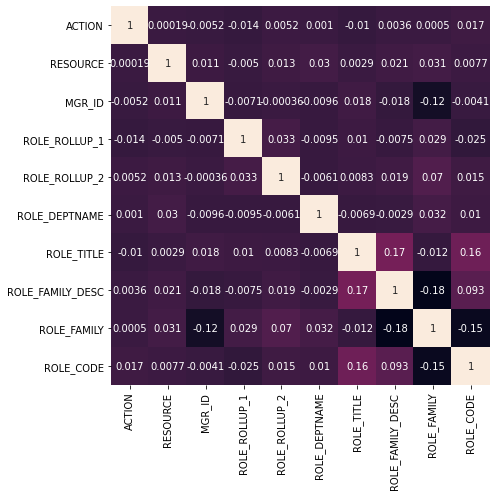

In [11]:
plt.figure(figsize=(12, 7))
corr_matrix = data_explore.corr()
sns.heatmap(corr_matrix, mask=np.zeros_like(corr_matrix, dtype=np.bool), square=True, annot=True, cbar=False)
plt.tight_layout()

In [3]:
corr_matrix['ACTION'].sort_values(ascending=False)

NameError: name 'corr_matrix' is not defined

- There is no attribute to which target variable is strongly correlated.

## Step 3: Data Preprocessing

In [8]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [9]:
X = data.drop(columns=['ACTION'], axis=1).copy()
y = data['ACTION'].copy()
X.shape, y.shape

NameError: name 'data' is not defined

In [10]:
cat_attrs = list(X.columns)
cat_attrs

NameError: name 'X' is not defined

In [ ]:
## Creating a MODEL and splitting the dataset into Train and Test data

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(X, y):
    strat_train_set = data.iloc[train_index]
    strat_test_set = data.iloc[test_index]

X_train = strat_train_set.drop('ACTION', axis=1)
y_train = strat_train_set['ACTION'].copy()
X_test = strat_test_set.drop('ACTION', axis=1)
y_test = strat_test_set['ACTION'].copy()
X_train.shape, X_test.shape

In [17]:
cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                         ('cat_enc', OneHotEncoder(handle_unknown='ignore'))])

pre_process = ColumnTransformer([('cat_process', cat_pipeline, cat_attrs)], remainder='passthrough')

X_train_transformed = pre_process.fit_transform(X_train)
X_test_transformed = pre_process.transform(X_test)
X_train_transformed.shape, X_test_transformed.shape

((26215, 14410), (6554, 14410))

- Since I will be using CatBoost Classifier. For CatBoost model, there is no need of encoding categorical model. Hence I will be creating a separate preprocessing pipeline for CatBoost model.

In [18]:
cat_boost_pre_process = ColumnTransformer([('imputer', SimpleImputer(strategy='most_frequent'), cat_attrs)], remainder='passthrough')

X_cb_train_transformed = cat_boost_pre_process.fit_transform(X_train)
X_cb_test_transformed = cat_boost_pre_process.transform(X_test)
X_cb_train_transformed.shape, X_cb_test_transformed.shape

((26215, 9), (6554, 9))

In [19]:
feature_columns = list(pre_process.transformers_[0][1]['cat_enc'].get_feature_names(cat_attrs))
len(feature_columns)

14410

## Step 4: Modelling

- Evaluation metric for this competition is ROC AUC Score.
- Since we have imbalance dataset, I will use Matthews correlation coefficient (MCC) as another evaluation metric. 
- Value of MCC is lies between -1 to +1. A coefficient of +1 represents a perfect prediction, 0 an average random prediction and -1 an inverse prediction.
    - ${MCC} = \frac{(TP + TN) * (FP + FN)}{\sqrt{( (TP +FP) * (TP + FN) * (TN + FP) * (TN + FN))}}$
    
- MCC value will be high only if model has high accuracy on predictions of negative data instances as well as of positive data instances.
- I will be selecting the best model with highest ROC AUC Score.

In [20]:
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [21]:
from sklearn.metrics import matthews_corrcoef, make_scorer, roc_auc_score, roc_curve
Matthew = make_scorer(matthews_corrcoef)

results = []

def plot_custom_roc_curve(clf_name, y_true, y_scores):
    auc_score = np.round(roc_auc_score(y_true, y_scores), 3)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    plt.plot(fpr, tpr, linewidth=2, label=clf_name+" (AUC Score: {})".format(str(auc_score)))
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel("FPR", fontsize=16)
    plt.ylabel("TPR", fontsize=16)
    plt.legend()
    
    
def performance_measures(model, X_tr=X_train_transformed, y_tr=y_train, X_ts=X_test_transformed, y_ts=y_test,
                         store_results=True):
    train_mcc = cross_val_score(model, X_tr, y_tr, scoring=Matthew, cv=kf, n_jobs=-1)
    test_mcc = cross_val_score(model, X_ts, y_ts, scoring=Matthew, cv=kf, n_jobs=-1)
    print("Mean Train MCC: {}\nMean Test MCC: {}".format(train_mcc.mean(), test_mcc.mean()))

    
    train_roc_auc = cross_val_score(model, X_tr, y_tr, scoring='roc_auc', cv=kf, n_jobs=-1)
    test_roc_auc = cross_val_score(model, X_ts, y_ts, scoring='roc_auc', cv=kf, n_jobs=-1)
    print("Mean Train ROC AUC Score: {}\nMean Test ROC AUC Score: {}".format(train_roc_auc.mean(), test_roc_auc.mean()))
    
    if store_results:
        results.append([model.__class__.__name__, np.round(np.mean(train_roc_auc), 3), np.round(np.mean(test_roc_auc), 3), np.round(np.mean(train_mcc), 3), np.round(np.mean(test_mcc), 3)])

In [22]:
def plot_feature_importance(feature_columns, importance_values, top_n_features=10):
    feature_imp = [ col for col in zip(feature_columns, importance_values)]
    feature_imp.sort(key=lambda x:x[1], reverse=True)
    
    if top_n_features:
        imp = pd.DataFrame(feature_imp[0:top_n_features], columns=['feature', 'importance'])
    else:
        imp = pd.DataFrame(feature_imp, columns=['feature', 'importance'])
    plt.figure(figsize=(10, 8))
    sns.barplot(y='feature', x='importance', data=imp, orient='h')
    plt.title('Most Important Features', fontsize=16)
    plt.ylabel("Feature", fontsize=16)
    plt.xlabel("")
    plt.show()

In [23]:
from sklearn.linear_model import LogisticRegression

logistic_reg = LogisticRegression(solver='liblinear', C=1, penalty='l2', max_iter=1000, random_state=42, n_jobs=-1)
logistic_reg.fit(X_train_transformed, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=-1, penalty='l2', random_state=42,
                   solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

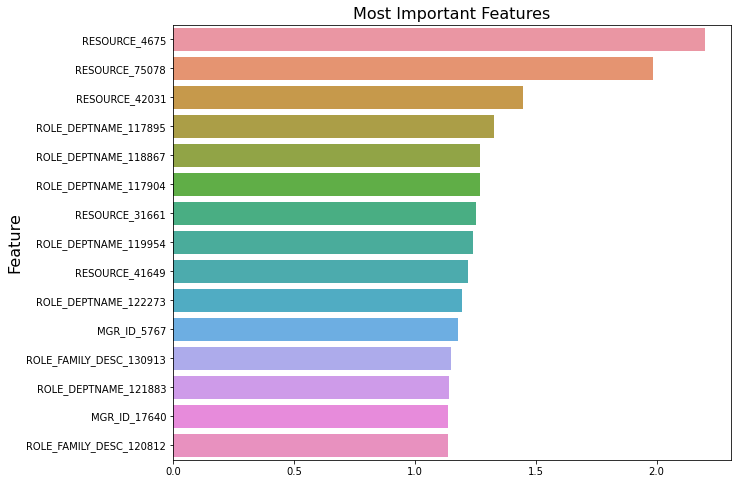

In [24]:
plot_feature_importance(feature_columns, logistic_reg.coef_[0], top_n_features=15)

In [25]:
performance_measures(logistic_reg)

Mean Train MCC: 0.2925811083941934
Mean Test MCC: 0.18388556695187624
Mean Train ROC AUC Score: 0.8470563332751307
Mean Test ROC AUC Score: 0.7517055122467291


In [26]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=300, max_depth=16, random_state=42,n_jobs=-1)
forest_clf.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=16, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

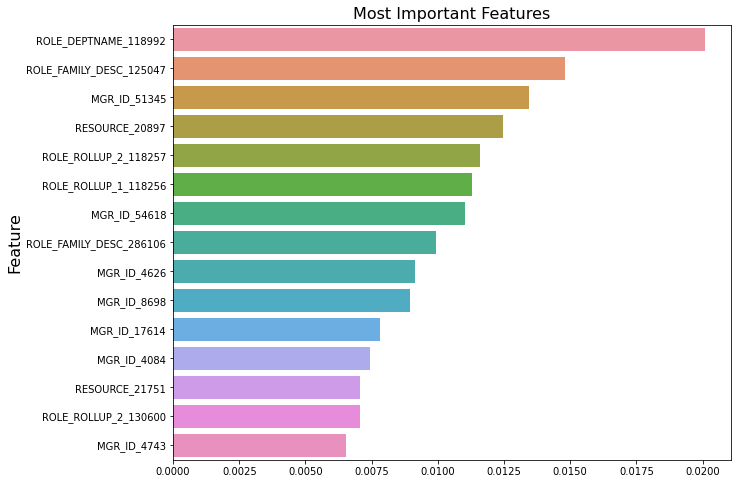

In [27]:
plot_feature_importance(feature_columns, forest_clf.feature_importances_, top_n_features=15)

In [28]:
performance_measures(forest_clf)

Mean Train MCC: 0.0
Mean Test MCC: 0.0
Mean Train ROC AUC Score: 0.8165212108561294
Mean Test ROC AUC Score: 0.7437150686782488


In [29]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(n_estimators=300, max_depth=16, learning_rate=0.1, random_state=42, n_jobs=-1)
xgb_clf.fit(X_train_transformed, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=16,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

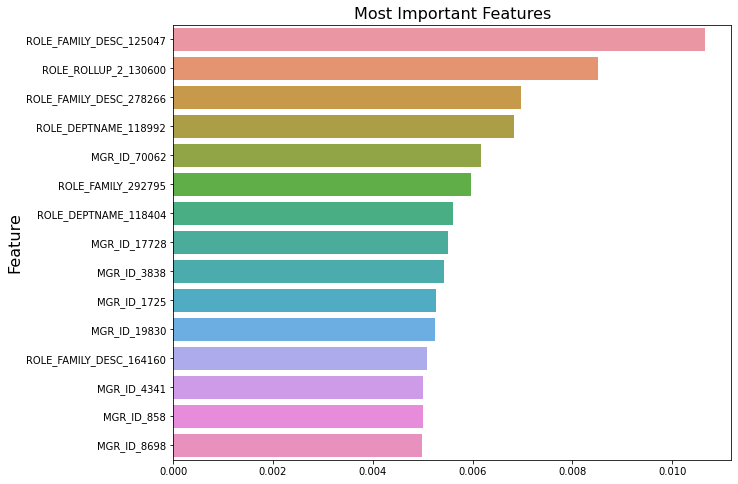

In [30]:
plot_feature_importance(feature_columns, xgb_clf.feature_importances_, top_n_features=15)

In [ ]:
performance_measures(xgb_clf)

Mean Train MCC: 0.39076287637260154
Mean Test MCC: 0.22660323395234597


In [ ]:
from catboost import CatBoostClassifier

catboost_clf = CatBoostClassifier(loss_function='Logloss', iterations=500, depth=6, l2_leaf_reg=1, 
                                  cat_features=list(range(X_cb_train_transformed.shape[1])), 
                                  eval_metric='AUC', random_state=42, verbose=0)
catboost_clf.fit(X_cb_train_transformed, y_train)

In [ ]:
performance_measures(catboost_clf, X_tr=X_cb_train_transformed, X_ts=X_cb_test_transformed)

In [ ]:
plot_feature_importance(feature_columns, catboost_clf.feature_importances_, top_n_features=15)

In [ ]:
logistic_reg_pipeline = Pipeline([('pre_process', pre_process), ('logistic_reg', logistic_reg)])
forest_clf_pipeline = Pipeline([('pre_process', pre_process), ('forest_clf', forest_clf)])
xgb_clf_pipeline = Pipeline([('pre_process', pre_process), ('xgb_clf', xgb_clf)])
catboost_clf_pipeline = Pipeline([('pre_process', cat_boost_pre_process), ('catboost_clf', catboost_clf)])

named_estimators = [('logistic_reg', logistic_reg_pipeline), ('forest_clf', forest_clf_pipeline), 
                    ('xgb_clf', xgb_clf_pipeline), ('catboost_clf', catboost_clf_pipeline)]

In [ ]:
from sklearn.ensemble import VotingClassifier

voting_reg = VotingClassifier(estimators=named_estimators, voting='soft', n_jobs=-1)
voting_reg.fit(X_train, y_train)

VotingClassifier(estimators=[('logistic_reg',
                              Pipeline(steps=[('pre_process',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('cat_process',
                                                                                Pipeline(steps=[('imputer',
                                                                                                 SimpleImputer(strategy='most_frequent')),
                                                                                                ('cat_enc',
                                                                                                 OneHotEncoder(handle_unknown='ignore'))]),
                                                                                ['RESOURCE',
                                                                                 'MGR_ID',
                            

In [ ]:
performance_measures(voting_reg, X_tr=X_train, X_ts=X_test)

Mean Train MCC: 0.29983537249602854
Mean Test MCC: 0.1726751317330924
Mean Train ROC AUC Score: 0.8688554833113686
Mean Test ROC AUC Score: 0.765211183456112


## Step 5: Model Evaluation

In [ ]:
result_df = pd.DataFrame(results, columns=['Model', 'CV Train AUC Score', 'CV Test AUC Score', 'CV Train MCC', 'CV Test MCC'])
result_df

,Model,CV Train AUC Score,CV Test AUC Score,CV Train MCC,CV Test MCC
0,LogisticRegression,0.847,0.752,0.293,0.184
1,RandomForestClassifier,0.817,0.744,0.000,0.000
2,XGBClassifier,0.836,0.725,0.391,0.227
3,CatBoostClassifier,0.882,0.778,0.490,0.258
4,VotingClassifier,0.869,0.765,0.300,0.173


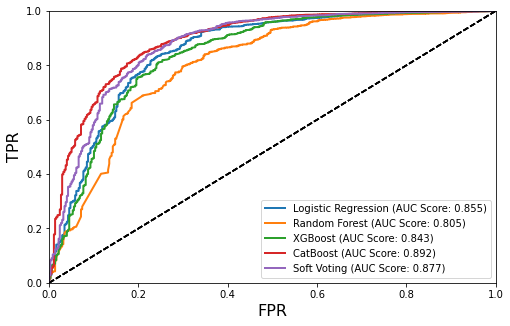

In [ ]:
plt.figure(figsize=(8, 5))
plot_custom_roc_curve('Logistic Regression', y_test, logistic_reg.decision_function(X_test_transformed))
plot_custom_roc_curve('Random Forest', y_test, forest_clf.predict_proba(X_test_transformed)[:,1])
plot_custom_roc_curve('XGBoost', y_test, xgb_clf.predict_proba(X_test_transformed)[:,1])
plot_custom_roc_curve('CatBoost', y_test, catboost_clf.predict_proba(X_cb_test_transformed)[:,1])
plot_custom_roc_curve('Soft Voting', y_test, voting_reg.predict_proba(X_test)[:,1])
plt.show()

## Step 6: Make submission

- Since Catboost Classifier has better ROC AUC Score and also good MCC value, I will be selecting Catboost as final model to make predictions on test dataset.

In [ ]:
final_model = Pipeline([('pre_process', cat_boost_pre_process),
                        ('catboost', catboost_clf)])
final_model.fit(X_train, y_train)

Pipeline(steps=[('pre_process',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('imputer',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['RESOURCE', 'MGR_ID',
                                                   'ROLE_ROLLUP_1',
                                                   'ROLE_ROLLUP_2',
                                                   'ROLE_DEPTNAME',
                                                   'ROLE_TITLE',
                                                   'ROLE_FAMILY_DESC',
                                                   'ROLE_FAMILY',
                                                   'ROLE_CODE'])])),
                ('catboost',
                 <catboost.core.CatBoostClassifier object at 0x7f1cafc86490>)])

In [ ]:
test_data = pd.read_csv('/content/test.csv')
test_data.head()

,id,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,78766,72734,118079,118080,117878,117879,118177,19721,117880
1,2,40644,4378,117961,118327,118507,118863,122008,118398,118865
2,3,75443,2395,117961,118300,119488,118172,301534,249618,118175
3,4,43219,19986,117961,118225,118403,120773,136187,118960,120774
4,5,42093,50015,117961,118343,119598,118422,300136,118424,118425


In [ ]:
output = pd.DataFrame(test_data['id'])
test_data = test_data.drop('id', axis=1)

In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58921 entries, 0 to 58920
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   RESOURCE          58921 non-null  int64
 1   MGR_ID            58921 non-null  int64
 2   ROLE_ROLLUP_1     58921 non-null  int64
 3   ROLE_ROLLUP_2     58921 non-null  int64
 4   ROLE_DEPTNAME     58921 non-null  int64
 5   ROLE_TITLE        58921 non-null  int64
 6   ROLE_FAMILY_DESC  58921 non-null  int64
 7   ROLE_FAMILY       58921 non-null  int64
 8   ROLE_CODE         58921 non-null  int64
dtypes: int64(9)
memory usage: 4.0 MB


In [ ]:
predictions = final_model.predict(test_data)

In [ ]:
output['ACTION'] = predictions.copy()

In [ ]:
output.head()

,id,ACTION
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


In [ ]:
output.to_csv("./submission.csv", index=False)